In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import pickle

import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    
with open('dataset-kernel-shap.pkl', 'rb') as f:
    ds = CPU_Unpickler(f).load()



# Extract the tensors
X, y, w = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights

print(f"Dataset shape: X={X.shape}, y={y.shape}, w={w.shape}")
print(f"Output range: [{y.min():.6f}, {y.max():.6f}]")
print(f"Weight range: [{w.min():.6f}, {w.max():.6f}]")
print(f"First sample: X[0].sum()={X[0].sum()}, y[0]=0.007214, w[0]=1.00e+06")

# Analyze convergence at different checkpoints
#checkpoints = [20, 50, 100, 200, 400, 600, 1000, 1500, 2000]
checkpoints = range(20, 2001, 20)
conv_distances = []
deltas = []
condition_numbers = []
avg_coefs = []

from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Lasso

beta_prev = None
for n in checkpoints:
    # Fit model with first n samples
    surrogate = Lasso(alpha=0.0005, max_iter=10000)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    # Calculate convergence distance
    if beta_prev is not None:
        conv_dist = torch.norm(beta - beta_prev, p=1).item()
        conv_distances.append(conv_dist)
    
    # Calculate delta_shap (local accuracy)
    f_x = y[0].item()  # unperturbed output
    delta = abs(f_x - (phi0 + phis.sum().item()))
    deltas.append(delta)
    
    # Calculate condition number of weighted design matrix
    X_n = X[:n].numpy()
    w_n = w[:n].numpy()
    W_sqrt = np.diag(np.sqrt(w_n.flatten()))
    # Add intercept column
    X_with_intercept = np.column_stack([np.ones(n), X_n])
    X_weighted_with_intercept = W_sqrt @ X_with_intercept
    try:
        cond = np.linalg.cond(X_weighted_with_intercept)
        condition_numbers.append(cond)
    except:
        condition_numbers.append(np.inf)

    # additionally consider the average of the absolute values of the coefficients
    avg_coef = phis.abs().mean().item()
    avg_coefs.append(avg_coef)
    
    print(f"\nn={n:4d}: delta={delta:.2e}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")
    print(f"        f(x)={f_x:.6f}, phi0+sum(phis)={phi0+phis.sum().item():.6f}")
    print(f"        Num non-zero coefs: {(phis.abs() > 1e-10).sum().item()}")
    if len(condition_numbers) > 0:
        print(f"        Condition number: {condition_numbers[-1]:.2e}")
    
    beta_prev = beta.detach().clone()



Dataset shape: X=torch.Size([2000, 384]), y=torch.Size([2000]), w=torch.Size([2000])
Output range: [0.000000, 0.007279]
Weight range: [1.000000, 1000000.000000]
First sample: X[0].sum()=384.0, y[0]=0.007214, w[0]=1.00e+06

n=  20: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(phis)=0.006214
        Num non-zero coefs: 8
        Condition number: 2.03e+04

n=  40: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(phis)=0.006214
        Num non-zero coefs: 11
        Condition number: 2.41e+04

n=  60: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(phis)=0.006214
        Num non-zero coefs: 6
        Condition number: 2.43e+04

n=  80: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(phis)=0.006214
        Num non-zero coefs: 9
        Condition number: 2.50e+04

n= 100: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(ph

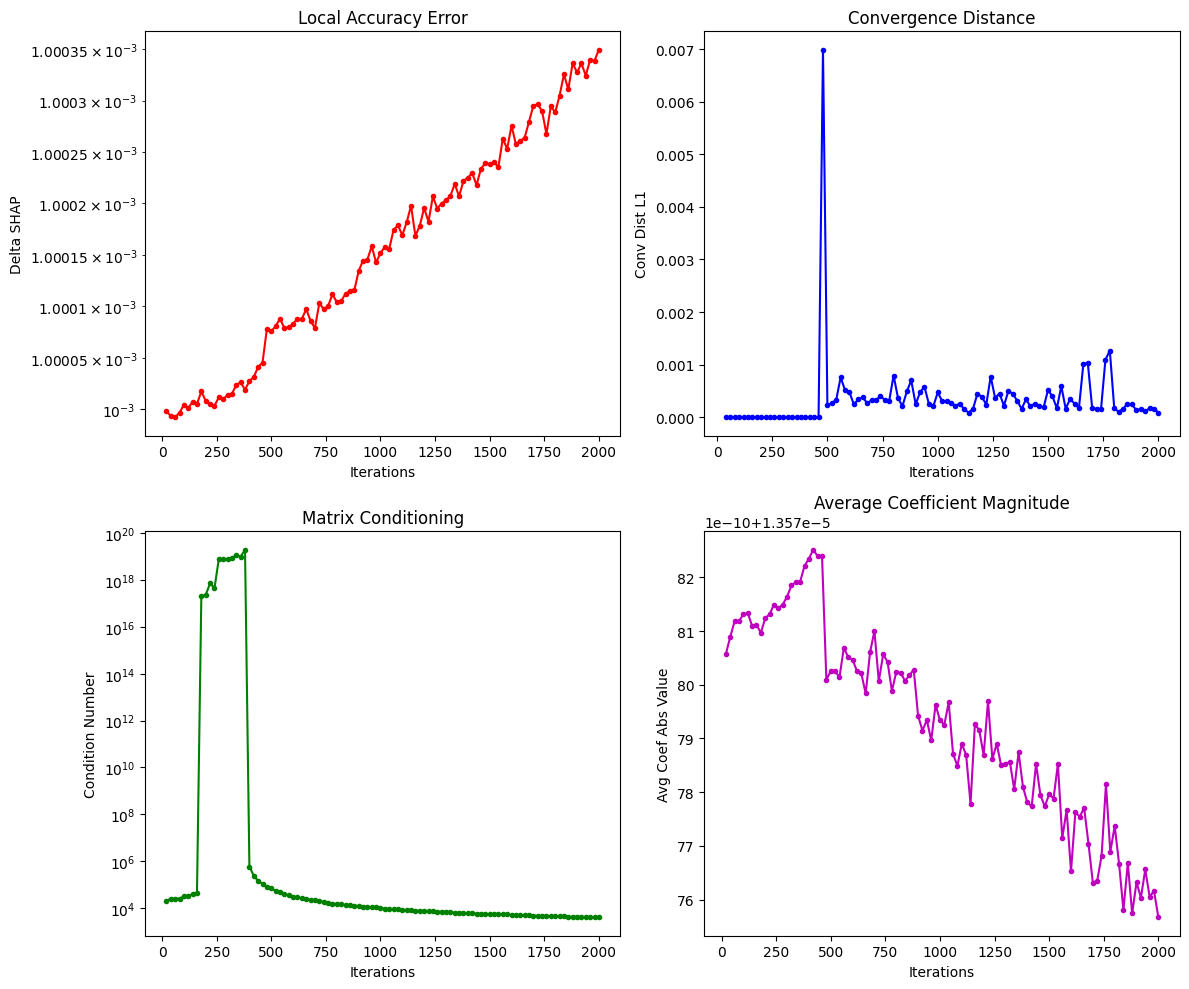


=== Additional Analysis ===
Number of unique samples: 1950
Number of all-zero samples: 1
Number of all-one samples: 1

=== Sample Diversity ===
Samples with exactly 1 features active: 176
Samples with exactly 5 features active: 34
Samples with exactly 10 features active: 19
Samples with exactly 50 features active: 2
Samples with exactly 100 features active: 1
Samples with exactly 383 features active: 149

=== Samples around position 170 ===
Sample 160: sum=383, y=0.007214, w=1
Sample 161: sum=363, y=0.006553, w=1
Sample 162: sum=56, y=0.000000, w=1
Sample 163: sum=272, y=0.005593, w=1
Sample 164: sum=122, y=0.001498, w=1
Sample 165: sum=2, y=0.000000, w=1
Sample 166: sum=333, y=0.007090, w=1
Sample 167: sum=156, y=0.005760, w=1
Sample 168: sum=340, y=0.006493, w=1
Sample 169: sum=380, y=0.007226, w=1
Sample 170: sum=383, y=0.007214, w=1
Sample 171: sum=1, y=0.000000, w=1
Sample 172: sum=339, y=0.007196, w=1
Sample 173: sum=46, y=0.000000, w=1
Sample 174: sum=383, y=0.007214, w=1
Sampl

In [2]:
# Plot analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Delta over iterations
axes[0,0].plot(checkpoints, deltas, 'r.-')
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Delta SHAP')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Local Accuracy Error')

# Convergence distance
if conv_distances:
    axes[0,1].plot(checkpoints[1:], conv_distances, 'b.-')
    axes[0,1].set_xlabel('Iterations')
    axes[0,1].set_ylabel('Conv Dist L1')
    axes[0,1].set_title('Convergence Distance')

# Condition numbers
axes[1,0].plot(checkpoints, condition_numbers, 'g.-')
axes[1,0].set_xlabel('Iterations')
axes[1,0].set_ylabel('Condition Number')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Matrix Conditioning')

# Plot average coefficients
axes[1,1].plot(checkpoints, avg_coefs, 'm.-')
axes[1,1].set_xlabel('Iterations')
axes[1,1].set_ylabel('Avg Coef Abs Value')
axes[1,1].set_title('Average Coefficient Magnitude')    

plt.tight_layout()
plt.show()

# Check specific properties
print("\n=== Additional Analysis ===")
print(f"Number of unique samples: {len(torch.unique(X, dim=0))}")
print(f"Number of all-zero samples: {(X.sum(dim=1) == 0).sum()}")
print(f"Number of all-one samples: {(X.sum(dim=1) == X.shape[1]).sum()}")

# Check sample diversity
print(f"\n=== Sample Diversity ===")
for k in [1, 5, 10, 50, 100, 383]:
    mask_k = (X.sum(dim=1) == k)
    print(f"Samples with exactly {k} features active: {mask_k.sum()}")

# Look for the problematic sample around 170
print(f"\n=== Samples around position 170 ===")

for i in range(160, 180):
    print(f"Sample {i}: sum={X[i].sum():.0f}, y={y[i]:.6f}, w={w[i]:.0f}")

# Check if there are any extreme outliers in outputs
print(f"\n=== Output distribution ===")
sorted_outputs = torch.sort(y)[0]
print(f"Min 5 outputs: {sorted_outputs[:5]}")
print(f"Max 5 outputs: {sorted_outputs[-5:]}")

In [3]:
print("condition numbers:")
print(len(condition_numbers))
print(checkpoints)
print([(i, condition_numbers[i//20-1]) for i in checkpoints])

condition numbers:
100
range(20, 2001, 20)
[(20, 20319.80772988343), (40, 24137.991763569516), (60, 24331.523905354145), (80, 24995.06357091029), (100, 30788.607000158623), (120, 32394.02818898437), (140, 38479.74672383023), (160, 42375.91895019986), (180, 2.1788459472021834e+17), (200, 2.338189121121193e+17), (220, 7.447066486103569e+17), (240, 4.531441901467369e+17), (260, 8.072516502073389e+18), (280, 7.916813038413586e+18), (300, 7.702547812203298e+18), (320, 8.738990907127635e+18), (340, 1.202966041035273e+19), (360, 1.032814916676174e+19), (380, 2.001395830032993e+19), (400, 582127.6509725752), (420, 235423.00266344455), (440, 142661.51623749753), (460, 105019.73195471348), (480, 78207.42935371687), (500, 68509.34295603403), (520, 53857.71585408218), (540, 47441.96903768006), (560, 39443.95548982118), (580, 34361.748024847584), (600, 30289.266182645777), (620, 28063.053264306203), (640, 25421.240390397434), (660, 23918.942184569612), (680, 22661.983774013785), (700, 21121.2742915

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import pickle

import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    
with open('dataset-kernel-shap.pkl', 'rb') as f:
    ds = CPU_Unpickler(f).load()



# Extract the tensors
X, y, w = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights

print(f"Dataset shape: X={X.shape}, y={y.shape}, w={w.shape}")
print(f"Output range: [{y.min():.6f}, {y.max():.6f}]")
print(f"Weight range: [{w.min():.6f}, {w.max():.6f}]")
print(f"First sample: X[0].sum()={X[0].sum()}, y[0]=0.007214, w[0]=1.00e+06")

# Analyze convergence at different checkpoints
#checkpoints = [20, 50, 100, 200, 400, 600, 1000, 1500, 2000]
checkpoints = range(160, 180, 1)
conv_distances = []
deltas = []
condition_numbers = []
avg_coefs = []

from sklearn.linear_model import LinearRegression as LinReg

beta_prev = None
for n in checkpoints:
    # Fit model with first n samples
    surrogate = Lasso(alpha=0.0005, max_iter=10000)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    # Calculate convergence distance
    if beta_prev is not None:
        conv_dist = torch.norm(beta - beta_prev, p=1).item()
        conv_distances.append(conv_dist)
    
    # Calculate delta_shap (local accuracy)
    f_x = y[0].item()  # unperturbed output
    delta = abs(f_x - (phi0 + phis.sum().item()))
    deltas.append(delta)
    
    # Calculate condition number of weighted design matrix
    X_n = X[:n].numpy()
    w_n = w[:n].numpy()
    W_sqrt = np.diag(np.sqrt(w_n.flatten()))
    # Add intercept column
    X_with_intercept = np.column_stack([np.ones(n), X_n])
    X_weighted_with_intercept = W_sqrt @ X_with_intercept
    try:
        cond = np.linalg.cond(X_weighted_with_intercept)
        condition_numbers.append(cond)
    except:
        condition_numbers.append(np.inf)

    # additionally consider the average of the absolute values of the coefficients
    avg_coef = phis.abs().mean().item()
    avg_coefs.append(avg_coef)
    
    print(f"\nn={n:4d}: delta={delta:.2e}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")
    print(f"        f(x)={f_x:.6f}, phi0+sum(phis)={phi0+phis.sum().item():.6f}")
    print(f"        Num non-zero coefs: {(phis.abs() > 1e-10).sum().item()}")
    if len(condition_numbers) > 0:
        print(f"        Condition number: {condition_numbers[-1]:.2e}")
    
    beta_prev = beta.detach().clone()



Dataset shape: X=torch.Size([2000, 384]), y=torch.Size([2000]), w=torch.Size([2000])
Output range: [0.000000, 0.007279]
Weight range: [1.000000, 1000000.000000]
First sample: X[0].sum()=384.0, y[0]=0.007214, w[0]=1.00e+06

n= 160: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(phis)=0.006214
        Num non-zero coefs: 8
        Condition number: 4.24e+04

n= 161: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(phis)=0.006214
        Num non-zero coefs: 7
        Condition number: 4.24e+04

n= 162: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(phis)=0.006214
        Num non-zero coefs: 8
        Condition number: 4.31e+04

n= 163: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(phis)=0.006214
        Num non-zero coefs: 8
        Condition number: 4.32e+04

n= 164: delta=1.00e-03, phi0=0.001000, sum(phis)=0.005214
        f(x)=0.007214, phi0+sum(phi

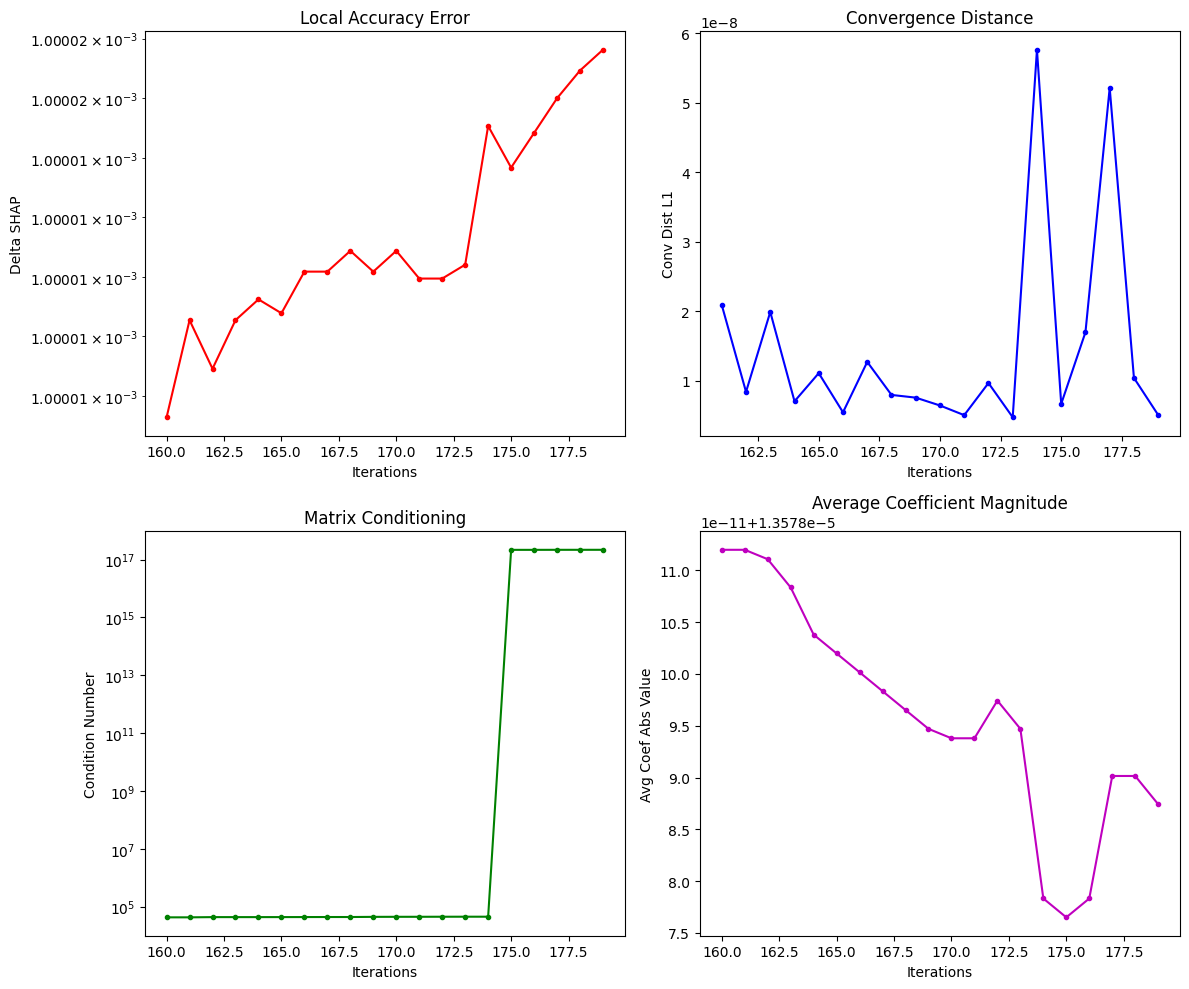


=== Additional Analysis ===
Number of unique samples: 1950
Number of all-zero samples: 1
Number of all-one samples: 1

=== Sample Diversity ===
Samples with exactly 1 features active: 176
Samples with exactly 5 features active: 34
Samples with exactly 10 features active: 19
Samples with exactly 50 features active: 2
Samples with exactly 100 features active: 1
Samples with exactly 383 features active: 149

=== Samples around position 170 ===
Sample 160: sum=383, y=0.007214, w=1
Sample 161: sum=363, y=0.006553, w=1
Sample 162: sum=56, y=0.000000, w=1
Sample 163: sum=272, y=0.005593, w=1
Sample 164: sum=122, y=0.001498, w=1
Sample 165: sum=2, y=0.000000, w=1
Sample 166: sum=333, y=0.007090, w=1
Sample 167: sum=156, y=0.005760, w=1
Sample 168: sum=340, y=0.006493, w=1
Sample 169: sum=380, y=0.007226, w=1
Sample 170: sum=383, y=0.007214, w=1
Sample 171: sum=1, y=0.000000, w=1
Sample 172: sum=339, y=0.007196, w=1
Sample 173: sum=46, y=0.000000, w=1
Sample 174: sum=383, y=0.007214, w=1
Sampl

In [5]:
# Plot analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Delta over iterations
axes[0,0].plot(checkpoints, deltas, 'r.-')
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Delta SHAP')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Local Accuracy Error')

# Convergence distance
if conv_distances:
    axes[0,1].plot(checkpoints[1:], conv_distances, 'b.-')
    axes[0,1].set_xlabel('Iterations')
    axes[0,1].set_ylabel('Conv Dist L1')
    axes[0,1].set_title('Convergence Distance')

# Condition numbers
axes[1,0].plot(checkpoints, condition_numbers, 'g.-')
axes[1,0].set_xlabel('Iterations')
axes[1,0].set_ylabel('Condition Number')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Matrix Conditioning')

# Plot average coefficients
axes[1,1].plot(checkpoints, avg_coefs, 'm.-')
axes[1,1].set_xlabel('Iterations')
axes[1,1].set_ylabel('Avg Coef Abs Value')
axes[1,1].set_title('Average Coefficient Magnitude')   


plt.tight_layout()
plt.show()

# Check specific properties
print("\n=== Additional Analysis ===")
print(f"Number of unique samples: {len(torch.unique(X, dim=0))}")
print(f"Number of all-zero samples: {(X.sum(dim=1) == 0).sum()}")
print(f"Number of all-one samples: {(X.sum(dim=1) == X.shape[1]).sum()}")

# Check sample diversity
print(f"\n=== Sample Diversity ===")
for k in [1, 5, 10, 50, 100, 383]:
    mask_k = (X.sum(dim=1) == k)
    print(f"Samples with exactly {k} features active: {mask_k.sum()}")

# Look for the problematic sample around 170
print(f"\n=== Samples around position 170 ===")
for i in range(160, 180):
    print(f"Sample {i}: sum={X[i].sum():.0f}, y={y[i]:.6f}, w={w[i]:.0f}")

# Check if there are any extreme outliers in outputs
print(f"\n=== Output distribution ===")
sorted_outputs = torch.sort(y)[0]
print(f"Min 5 outputs: {sorted_outputs[:5]}")
print(f"Max 5 outputs: {sorted_outputs[-5:]}")

In [6]:
print("174th sample: ", X[174], y[174].item(), w[174].item())


174th sample:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1

In [7]:
print("index of the only 0 feature: ", (X[174] == 0).nonzero(as_tuple=True)[0].item())

index of the only 0 feature:  299



n=   1: phiavg=0.000000, n_features=0 phi0=0.007214, sum(phis)=0.000000

n=   6: phiavg=0.000014, n_features=2 phi0=0.001000, sum(phis)=0.005214

n=  11: phiavg=0.000014, n_features=3 phi0=0.001000, sum(phis)=0.005214

n=  16: phiavg=0.000014, n_features=5 phi0=0.001000, sum(phis)=0.005214

n=  21: phiavg=0.000014, n_features=7 phi0=0.001000, sum(phis)=0.005214

n=  26: phiavg=0.000014, n_features=6 phi0=0.001000, sum(phis)=0.005214

n=  31: phiavg=0.000014, n_features=8 phi0=0.001000, sum(phis)=0.005214

n=  36: phiavg=0.000014, n_features=13 phi0=0.001000, sum(phis)=0.005214

n=  41: phiavg=0.000014, n_features=11 phi0=0.001000, sum(phis)=0.005214

n=  46: phiavg=0.000014, n_features=10 phi0=0.001000, sum(phis)=0.005214

n=  51: phiavg=0.000014, n_features=10 phi0=0.001000, sum(phis)=0.005214

n=  56: phiavg=0.000014, n_features=8 phi0=0.001000, sum(phis)=0.005214

n=  61: phiavg=0.000014, n_features=6 phi0=0.001000, sum(phis)=0.005214

n=  66: phiavg=0.000014, n_features=7 phi0=0.0

/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 1.0, 'Average coefficient of features over iterations')

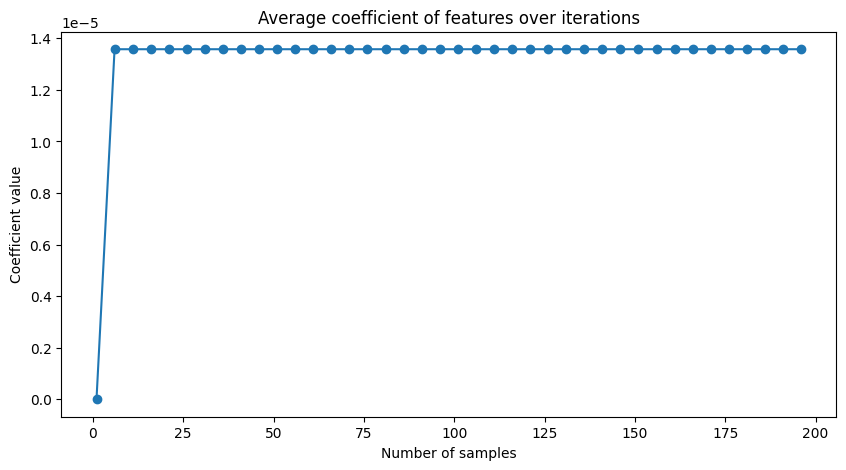

In [ ]:
# examine model weight of the average of the features from 0 to the 200th sample
checkpoints = range(1,200,5)
phis_v = []
for n in checkpoints:
    # Fit model with first n samples\
    surrogate = Lasso(alpha=0.0005, max_iter=10000)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    print(f"\nn={n:4d}: phiavg={phis.abs().mean().item():.6f}, n_features={(phis.abs() > 1e-10).sum().item()} phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

    # save the average coefficient
    phis_v.append(phis.abs().mean().item())

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Average coefficient of features over iterations')

/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


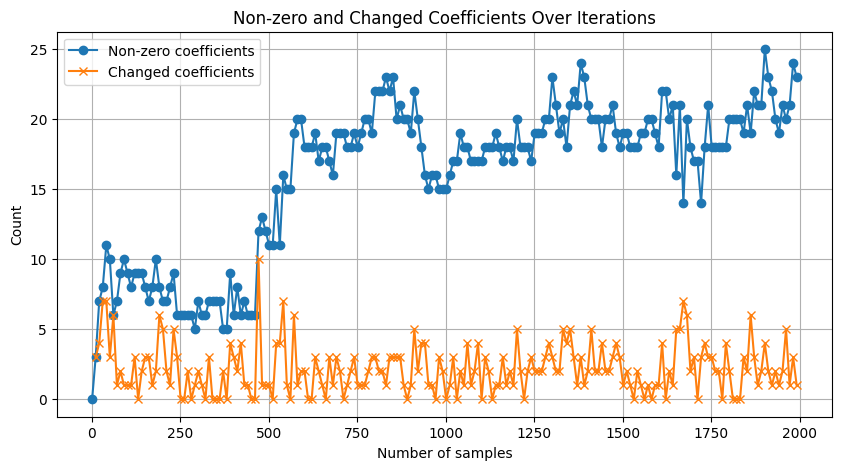

In [9]:
# plot the number of non-zero coefficients that change over iterations
checkpoints = range(1,2000,10)
phis_v = []
non_zero_coeffs_prev = None
non_zero_coeffs_vector = []
non_zero_changed_vector = []
for n in checkpoints:
    # Fit model with first n samples\
    surrogate = Lasso(alpha=0.0005, max_iter=10000)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    non_zero_coeffs = (phis.abs() > 1e-10)
    num_non_zero = non_zero_coeffs.sum().item()

    changed_coeffs = (non_zero_coeffs != non_zero_coeffs_prev).sum().item() if non_zero_coeffs_prev is not None else None
    non_zero_coeffs_prev = non_zero_coeffs.clone()

    non_zero_coeffs_vector.append(num_non_zero)
    non_zero_changed_vector.append(changed_coeffs)

# Plot the number of non-zero coefficients and changes over iterations
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, non_zero_coeffs_vector, marker='o', label='Non-zero coefficients')
plt.plot(checkpoints, non_zero_changed_vector, marker='x', label='Changed coefficients')
plt.xlabel('Number of samples')
plt.ylabel('Count')
plt.title('Non-zero and Changed Coefficients Over Iterations')
plt.legend()
plt.grid()
plt.show()
